2025-08-29 14:22:50 INFO     xscen.config    Updated the config with ../paths_obs.yml.
2025-08-29 14:22:50 INFO     xscen.config    Updated the config with ../config_obs.yml.
/tmp/ipykernel_4100268/3328994045.py:37: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

/tmp/ipykernel_4100268/3328994045.py:38: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.



Régions administratives du Québec


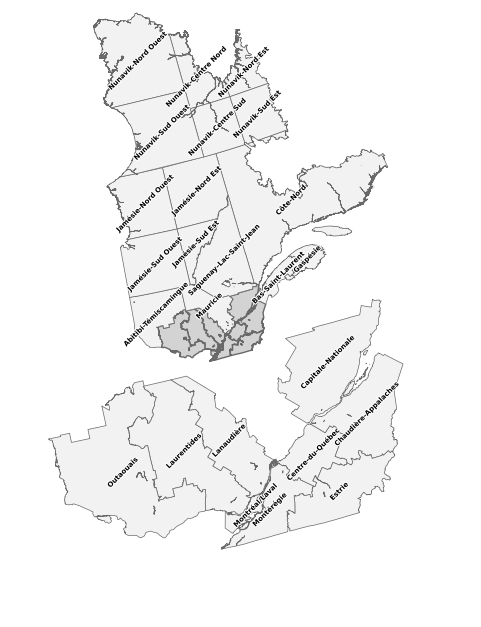

In [1]:
import geopandas as gpd
import matplotlib.pyplot as plt
from xscen.config import CONFIG
import xscen as xs
import matplotlib.patheffects as path_effects
from plot_settings import PROJECTION, EXTENT, DPI, save_plot
import cartopy.crs as ccrs
from cartopy.feature import ShapelyFeature
import os
fig_path = CONFIG["paths"]["figures"]

# --- Styling ---
facecolor_land = "#f2f2f2"
facecolor_highlight = "lightgray"

# --- Load config ---
xs.load_config("../paths_obs.yml", "../config_obs.yml", verbose=(__name__ == "__main__"), reset=True)

# --- Load shapefile ---
gdf = gpd.read_file("../" + CONFIG["regional_mean"]["region"]["shape"])

# --- Accurate centroid handling ---

# Project to same CRS as map for accurate centroid calculation
gdf_proj = gdf.to_crs(PROJECTION.proj4_params)

# Compute centroids in projected space
gdf_proj["centroid"] = gdf_proj.geometry.centroid

# Transform centroids back to lon/lat for plotting on PlateCarree
gdf["centroid_lon"] = gdf_proj["centroid"].to_crs("EPSG:4326").x
gdf["centroid_lat"] = gdf_proj["centroid"].to_crs("EPSG:4326").y

# --- Split regions above/below Outaouais centroid y ---
outaouais_geom = gdf[gdf["name"] == "Mauricie"].geometry.values[0]
outaouais_y = outaouais_geom.centroid.y
gdf_above = gdf[gdf.geometry.centroid.y >= outaouais_y]
gdf_below = gdf[gdf.geometry.centroid.y < outaouais_y]

# --- Create figure and subplots ---
fig, (ax1, ax2) = plt.subplots(
    2, 1,
    figsize=(8, 8),
    gridspec_kw={'height_ratios': [1, 1]},
    subplot_kw={'projection': PROJECTION}
)

# --- Subplot 1: All regions ---

# Fill below regions (highlighted)
ax1.add_feature(ShapelyFeature(
    gdf_below.geometry,
    ccrs.PlateCarree(),
    facecolor=facecolor_highlight,
    edgecolor='dimgray',
    linewidths=1.0,
    zorder=0
))

# Fill above regions (land)
ax1.add_feature(ShapelyFeature(
    gdf_above.geometry,
    ccrs.PlateCarree(),
    facecolor=facecolor_land,
    edgecolor='dimgray',
    linewidths=0.5,
    zorder=0
))

# Annotate above regions
for _, row in gdf_above.iterrows():
    ax1.annotate(
        row["name"],
        xy=(row["centroid_lon"], row["centroid_lat"]),
        fontsize=5,
        ha='center',
        va='center',
        rotation=45,
        fontweight='bold',
        transform=ccrs.PlateCarree(),
        path_effects=[path_effects.withStroke(linewidth=1.5, foreground='white')]
    )

ax1.axis("off")

# --- Subplot 2: Only regions below Outaouais ---

# Fill below regions (land)
ax2.add_feature(ShapelyFeature(
    gdf_below.geometry,
    ccrs.PlateCarree(),
    facecolor=facecolor_land,
    edgecolor='dimgray',
    linewidths=0.5,
    zorder=0
))

# Annotate below regions
for _, row in gdf_below.iterrows():
    ax2.annotate(
        row["name"],
        xy=(row["centroid_lon"], row["centroid_lat"]),
        fontsize=5,
        ha='center',
        va='center',
        rotation=45,
        fontweight='bold',
        transform=ccrs.PlateCarree(),
        path_effects=[path_effects.withStroke(linewidth=1.5, foreground='white')]
    )

ax2.axis("off")

# --- Final layout ---
plt.subplots_adjust(hspace=-0.3, top=0.96, bottom=0.2)
print("Régions administratives du Québec")

ax1.set_extent(EXTENT)


# Auto-compute extent for southern regions (gdf_below)
minx, miny, maxx, maxy = gdf_below.total_bounds

# Optional: Add padding (in degrees)
pad_x = 0.5
pad_y = 0.5
ax2.set_extent([minx - pad_x, maxx + pad_x, miny - pad_y, maxy + pad_y], crs=ccrs.PlateCarree())

save_plot(fig, processing_level="extra", horizon="NA", freq="NA", file_name="regions")

plt.show()
